In [1]:
import os, codecs, json, time
import pandas as pd
import numpy as np
import sklearn as sl
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
INPUT_TRAIN_FILE='data\\train.csv'
INPUT_TEST_FILE='data\\test.csv'
FLATTEN_FLAG = False

In [3]:
st = time.time()
train_df = pd.read_csv(INPUT_TRAIN_FILE, nrows=1000)
print ("Reading", time.time()-st)
print (len(train_df))

Reading 0.5303359031677246
1000


In [4]:
train_df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [5]:
train_df.device[0]

'{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Windows", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}'

In [6]:
train_df.geoNetwork[0]

'{"continent": "Asia", "subContinent": "Western Asia", "country": "Turkey", "region": "Izmir", "metro": "(not set)", "city": "Izmir", "cityId": "not available in demo dataset", "networkDomain": "ttnet.com.tr", "latitude": "not available in demo dataset", "longitude": "not available in demo dataset", "networkLocation": "not available in demo dataset"}'

In [7]:
train_df.totals[0]

'{"visits": "1", "hits": "1", "pageviews": "1", "bounces": "1", "newVisits": "1"}'

In [8]:
train_df.trafficSource[0]

'{"campaign": "(not set)", "source": "google", "medium": "organic", "keyword": "(not provided)", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}}'

In [9]:
train_df.describe()

,date,fullVisitorId,visitId,visitNumber,visitStartTime
count,1000.0,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03
mean,20160902.0,4.545762e+18,1.472841e+09,2.035000,1.472841e+09
std,0.0,3.053412e+18,2.240422e+04,6.515384,2.240424e+04
min,20160902.0,2.953262e+15,1.472800e+09,1.000000,1.472800e+09
25%,20160902.0,1.647353e+18,1.472824e+09,1.000000,1.472824e+09
50%,20160902.0,4.418539e+18,1.472840e+09,1.000000,1.472840e+09
75%,20160902.0,7.256540e+18,1.472858e+09,1.000000,1.472858e+09
max,20160902.0,9.991882e+18,1.472886e+09,136.000000,1.472886e+09


As a result, we have to deal with fields written in JSON format.

In [10]:
from pandas.io.json import json_normalize
json_fields = ['device', 'geoNetwork', 'totals', 'trafficSource']
def flatten(flag=False):
    if not flag:
        return   
    df = pd.read_csv(INPUT_TRAIN_FILE, 
                     converters={column: json.loads for column in json_fields}, 
                     dtype={'fullVisitorId': 'str'})
    
    for col in json_fields:
        col_as_df = json_normalize(df[col])
        col_as_df.columns = [f"{col}.{subcol}" for subcol in col_as_df.columns]
        df = df.drop(col, axis=1).merge(col_as_df, right_index=True, left_index=True)
    df.to_csv('data\\f_train.csv')
    del df
    df = pd.read_csv(INPUT_TEST_FILE, 
                     converters={column: json.loads for column in json_fields}, 
                     dtype={'fullVisitorId': 'str'})
    
    for col in json_fields:
        col_as_df = json_normalize(df[col])
        col_as_df.columns = [f"{col}.{subcol}" for subcol in col_as_df.columns]
        df = df.drop(col, axis=1).merge(col_as_df, right_index=True, left_index=True)
    df.to_csv('data\\f_test.csv')
flatten(FLATTEN_FLAG)
train_df_f = pd.read_csv('data\\f_train.csv', 
                     dtype={'fullVisitorId': 'str'})

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
train_df_f.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


Browse the flattened file in Microsoft Excel, I see the values of colmns, especially for those text data. I decided to write lines of codes to automatically identicate how many categories they have. Text data can be view into two groups: plain string data like ID# and category data. Some colomns contains integer value can also be regarded as category data.

Real number data:
 - visitNumber
 - totals.hits
 - totals.pageviews
 - totals.transactionRevenue

Datetime data:
 - date
 - visitStartTime (TimeStamp)

Plain string data:
 - fullVisitorId
 - visitId
 - sessionId
 
Category data:
 - channelGrouping
 - socialEngagementType
 - device.browser
 - device.browserSize
 - device.browserVersion
 - device.deviceCategory
 - device.flashVersion
 - device.isMobile
 - device.language
 - device.mobileDeviceBranding
 - device.mobileDeviceInfo
 - device.mobileDeviceMarketingName
 - device.mobileDeviceModel
 - device.mobileInputSelector
 - device.operatingSystem
 - device.operatingSystemVersion
 - device.screenColors
 - device.screenResolution
 - geoNetwork.city
 - geoNetwork.cityId
 - geoNetwork.continent
 - geoNetwork.country
 - geoNetwork.latitude
 - geoNetwork.longitude
 - geoNetwork.metro
 - geoNetwork.networkDomain
 - geoNetwork.networkLocation
 - geoNetwork.region
 - geoNetwork.subContinent
 - totals.bounces
 - totals.newVisits
 - totals.transactionRevenue
 - totals.visits
 - trafficSource.adContent
 - trafficSource.adwordsClickInfo.adNetworkType
 - trafficSource.adwordsClickInfo.criteriaParameters
 - trafficSource.adwordsClickInfo.gclId
 - trafficSource.adwordsClickInfo.isVideoAd
 - trafficSource.adwordsClickInfo.page
 - trafficSource.adwordsClickInfo.slot
 - trafficSource.campaign
 - trafficSource.campaignCode
 - trafficSource.isTrueDirect
 - trafficSource.keyword
 - trafficSource.medium
 - trafficSource.referralPath
 - trafficSource.source

In [12]:
CATEGORY_COLUMN_NAMES = [
    'channelGrouping',
    'socialEngagementType',
    'device.browser',
    'device.browserSize',
    'device.browserVersion',
    'device.deviceCategory',
    'device.flashVersion',
    'device.isMobile',
    'device.language',
    'device.mobileDeviceBranding',
    'device.mobileDeviceInfo',
    'device.mobileDeviceMarketingName',
    'device.mobileDeviceModel',
    'device.mobileInputSelector',
    'device.operatingSystem',
    'device.operatingSystemVersion',
    'device.screenColors',
    'device.screenResolution',
    'geoNetwork.city',
    'geoNetwork.cityId',
    'geoNetwork.continent',
    'geoNetwork.country',
    'geoNetwork.latitude',
    'geoNetwork.longitude',
    'geoNetwork.metro',
    'geoNetwork.networkDomain',
    'geoNetwork.networkLocation',
    'geoNetwork.region',
    'geoNetwork.subContinent',
    'totals.bounces',
    'totals.newVisits',
    'totals.transactionRevenue',
    'totals.visits',
    'trafficSource.adContent',
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.criteriaParameters',
    'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.isVideoAd',
    'trafficSource.adwordsClickInfo.page',
    'trafficSource.adwordsClickInfo.slot',
    'trafficSource.campaign',
    'trafficSource.campaignCode',
    'trafficSource.isTrueDirect',
    'trafficSource.keyword',
    'trafficSource.medium',
    'trafficSource.referralPath',
    'trafficSource.source',
]

Check values and their counts in each column.

In [13]:
for col in CATEGORY_COLUMN_NAMES:
    print (train_df_f[col].value_counts())

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64
Not Socially Engaged    903653
Name: socialEngagementType, dtype: int64
Chrome                                         620364
Safari                                         182245
Firefox                                         37069
Internet Explorer                               19375
Edge                                            10205
Android Webview                                  7865
Safari (in-app)                                  6850
Opera Mini                                       6139
Opera                                            5643
UC Browser                                       2427
YaBrowser                                        2096
Coc Coc                                           727
Amazon Silk                                 

not available in demo dataset                508229
(not set)                                    201766
San Francisco-Oakland-San Jose CA             95913
New York NY                                   26917
London                                        12571
Los Angeles CA                                 9995
Seattle-Tacoma WA                              7642
Chicago IL                                     7585
Austin TX                                      3790
Washington DC (Hagerstown MD)                  3380
Boston MA-Manchester NH                        2628
Houston TX                                     2475
Atlanta GA                                     2463
Detroit MI                                     2403
Roanoke-Lynchburg VA                           2227
Dallas-Ft. Worth TX                            2012
San Diego CA                                   1364
Portland OR                                    1319
Pittsburgh PA                                  1076
Denver CO   

Name: trafficSource.adContent, dtype: int64
Google Search      21453
Search partners        7
Name: trafficSource.adwordsClickInfo.adNetworkType, dtype: int64
not available in demo dataset    903653
Name: trafficSource.adwordsClickInfo.criteriaParameters, dtype: int64
Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3ZdwYO8GTsjiBFd5MPHStZa9y_9NCrI8X97oaAglc8P8HAQ      70
Cj0KEQjw1ee_BRD3hK6x993YzeoBEiQA5RH_BEA562M9tvl_mtnAFvtDnDqOQRp1RvxMMgwjcX1LAfwaAj4o8P8HAQ      41
CJH1vbf94M8CFUElgQodyakHgQ                                                                      29
Cj0KEQiAw_DEBRChnYiQ_562gsEBEiQA4LcssmB_RWgvpPnltzlzj5rGwqx5lk87wC5CjfcqzneNZewaAiAp8P8HAQ      27
CjwKEAiAj7TCBRCp2Z22ue-zrj4SJACG7SBEJui6ggr6ocA-eDC2-lX7W1m5IA1c_qNbzwZVTqUanxoCb5rw_wcB        24
CN_u9PaVhdACFcNahgodTCQAjw                                                                      22
CjwKEAiAxKrFBRDm25f60OegtwwSJABgEC-Z0_DLPcXHm1ZTqlR1YWeWXU875yaqwupt7pGMgFEZThoCeEzw_wcB        21
CNHp7Nf2ytMCFVlWDQod_IoL5A            

Name: trafficSource.keyword, Length: 3659, dtype: int64
organic      381561
referral     330955
(none)       143026
cpc           25326
affiliate     16403
cpm            6262
(not set)       120
Name: trafficSource.medium, dtype: int64
/                                                                                                                                                                               75523
/yt/about/                                                                                                                                                                      71036
/analytics/web/                                                                                                                                                                 14620
/yt/about/tr/                                                                                                                                                                   14599
/yt/about/vi/                      

From above we can observe that, category colmns listed below are only have one value:
 - socialEngagementType
 - device.browserSize
 - device.browserVersion
 - device.flashVersion
 - device.language
 - device.mobileDeviceBranding 
 - device.mobileDeviceInfo 
 - device.mobileDeviceMarketingName 
 - device.mobileDeviceModel 
 - device.mobileInputSelector 
 - device.operatingSystemVersion
 - device.screenColors
 - device.screenResolution
 - geoNetwork.cityId
 - geoNetwork.latitude
 - geoNetwork.longitude
 - geoNetwork.networkLocation
 - totals.newVisits
 - totals.visits
 - trafficSource.adwordsClickInfo.criteriaParameters
 
 
Therefore, they can be totally removed from the dataset.

In [14]:
SINGLE_VALUE_COLUMN_NAMES = [
    "socialEngagementType",
    "device.browserSize",
    "device.browserVersion",
    "device.flashVersion",
    "device.language",
    "device.mobileDeviceBranding",
    "device.mobileDeviceInfo",
    "device.mobileDeviceMarketingName",
    "device.mobileDeviceModel",
    "device.mobileInputSelector",
    "device.operatingSystemVersion",
    "device.screenColors",
    "device.screenResolution",
    "geoNetwork.cityId",
    "geoNetwork.latitude",
    "geoNetwork.longitude",
    "geoNetwork.networkLocation",
    "totals.visits",
    "trafficSource.adwordsClickInfo.criteriaParameters",
]
train_df_f.drop(columns=SINGLE_VALUE_COLUMN_NAMES, inplace=True)

To moving forward, I try to figure out what the exact meaning of remaining columns.
With the help the [help information of Google Analytics](https://support.google.com/analytics/answer/3437719), I can figure out the meaning of almost all columns. I would like write some notes about features which are not computer devices and systems related.
 - channelGrouping: the method of a customer visit the page.
 - fullVisitorId: the unique identifier of a customer.
 - visitNumber: total accumulated numbers of this customer visiting the page.
 - visitStartTime: the POSIX timestamp when starting the visit. visitId is the same as this.
 - geoNetwork.metro: the DMA (distriction of marketing area) of a session starting. It's also a geo infomation.
 - geoNetwork.region: the region of a session starting. It's a geo information again, which has less avaliable information than geoNetwork.city.
 - totals.bounces: the number of bounces.
 - totals.hits: total numbers of matched results, if using a search engine.
 - totals.pageviews: the number of webpages in this session. It can be interpreted as how many webpages of this store are opened by a customer in this shopping.
 - totals.transactionRevenue: the total value of a transction multiplied by $10^6$.
 - trafficSource.adContent: abstract of an AD if provided
 - trafficSource.adwordsClickInfo.adNetworkType: the type of a network.
 - trafficSource.adwordsClickInfo.gclId: a unique tracking string used by Google to pass information back and forth between Google AdWords and Google Analytics.
 - trafficSource.adwordsClickInfo.isVideoAd: whether the Ad is a video. Blank value is speculated as True.
 - trafficSource.adwordsClickInfo.slot: the positon of the Ad on the webpage. 'Top' for the top, 'RHS' for right-hand-side.
 - trafficSource.campaign: a parameter of an AD.
 - trafficSource.campaignCode: a code used to track the AD.
 - trafficSource.isTrueDirect: If the user directly open the page by entering the URL or bookmark, it's True. 
 - trafficSource.keyword: given keywords if using search.
 - trafficSource.referralPath: the webpage path before being redirected to the store, if the "channelGrouping" is "referral".
 - trafficSource.source: the domain name before being redirected.
 
Find that some columns are either hard to use or containing unrelated or duplicated informations. They can be removed:
 - sessionId
 - visitId
 - geoNetwork.metro
 - geoNetwork.region
 - totals.bounces
 - trafficSource.campaign
 - trafficSource.campaignCode
 - trafficSource.adwordsClickInfo.adNetworkType
 - trafficSource.adwordsClickInfo.gclId
 - trafficSource.referralPath
and the index column.

In [15]:
USELESS_COLUMN_NAMES = [
    "visitId",
    "sessionId",
    "geoNetwork.metro",
    "geoNetwork.region",
    "totals.bounces",
    "trafficSource.campaign",
    "trafficSource.campaignCode",
    "trafficSource.adwordsClickInfo.adNetworkType",
    "trafficSource.adwordsClickInfo.gclId",
    "trafficSource.referralPath",
]
train_df_f.drop(columns=USELESS_COLUMN_NAMES, inplace=True)

Fill `NaN` or `Null` value with 0

In [243]:
train_df_f["totals.newVisits"].fillna(0, inplace=True)
train_df_f["totals.transactionRevenue"].fillna(0, inplace=True)

Then, deal with the boolean values. Some of the boolean values are defined by TRUE or FALSE and read by pandas as an object, convert them to integer values which only contain 0 and 1. Also do other nessary type changes to some columns.

In [244]:
train_df_f.dtypes

dtype('float64')

In [ ]:
train_df_f['totals.newVisits'] = train_df_f['totals.newVisits'].astype('int32')

In [17]:
train_df_f['trafficSource.adwordsClickInfo.isVideoAd'].loc[train_df_f['trafficSource.adwordsClickInfo.isVideoAd']!='FALSE'] = 1
train_df_f['trafficSource.adwordsClickInfo.isVideoAd'].loc[train_df_f['trafficSource.adwordsClickInfo.isVideoAd']=='True'] = 0
train_df_f['trafficSource.adwordsClickInfo.isVideoAd'] = train_df_f['trafficSource.adwordsClickInfo.isVideoAd'].astype('int32')
train_df_f['trafficSource.adwordsClickInfo.isVideoAd'].dtype

C:\Users\etoss\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


dtype('bool')

In [18]:
train_df_f['trafficSource.isTrueDirect'].loc[train_df_f['trafficSource.isTrueDirect']!='TRUE'] = 0
train_df_f['trafficSource.isTrueDirect'].loc[train_df_f['trafficSource.isTrueDirect']=='TRUE'] = 1
train_df_f['trafficSource.isTrueDirect'] = train_df_f['trafficSource.isTrueDirect'].astype('int32')
train_df_f['trafficSource.isTrueDirect'].dtype

C:\Users\etoss\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


dtype('bool')

Parsing timestamp

In [20]:
def split_datetime(df):
    new_years, new_months, new_days, new_hour, new_weekday = zip(*[(d.year, d.month, d.day, d.hour, d.weekday()) for d in pd.to_datetime(df.visitStartTime, unit='s')])
    df = df.assign(visit_year=new_years, 
                   visit_month=new_months, 
                   visit_day=new_days, 
                   visit_hour=new_hour, 
                   visit_weekday=new_weekday)
    return df.drop(columns=['visitStartTime', 'date'])
train_df_f = split_datetime(train_df_f)

Write the cleaned file

In [21]:
WASH_FLAG = True
if WASH_FLAG:
    train_df_f.to_csv('data\\w_train.csv', index=False)

Do the same procedures on the test data.

In [22]:
if WASH_FLAG:
    test_df_f = pd.read_csv('data\\f_test.csv', 
                         dtype={'fullVisitorId': 'str'})
    test_df_f.drop(columns=SINGLE_VALUE_COLUMN_NAMES, inplace=True)
    TEST_USELESS_COLUMN_NAMES = [
        "visitId",
        "sessionId",
        "geoNetwork.metro",
        "geoNetwork.region",
        "totals.bounces",
        "trafficSource.campaign",
        "trafficSource.adwordsClickInfo.adNetworkType",
        "trafficSource.adwordsClickInfo.gclId",
        "trafficSource.referralPath",
    ]
    test_df_f.drop(columns=TEST_USELESS_COLUMN_NAMES, inplace=True)
    test_df_f['trafficSource.adwordsClickInfo.isVideoAd'].loc[test_df_f['trafficSource.adwordsClickInfo.isVideoAd']!='FALSE'] = 1
    test_df_f['trafficSource.adwordsClickInfo.isVideoAd'].loc[test_df_f['trafficSource.adwordsClickInfo.isVideoAd']=='FALSE'] = 0
    test_df_f['trafficSource.adwordsClickInfo.isVideoAd'] = test_df_f['trafficSource.adwordsClickInfo.isVideoAd'].astype('int32')
    test_df_f['trafficSource.isTrueDirect'].loc[test_df_f['trafficSource.isTrueDirect']!='TRUE'] = 0
    test_df_f['trafficSource.isTrueDirect'].loc[test_df_f['trafficSource.isTrueDirect']=='TRUE'] = 1
    test_df_f['trafficSource.isTrueDirect'] = test_df_f['trafficSource.isTrueDirect'].astype('int32')
    test_df_f = split_datetime(test_df_f)

    test_df_f.to_csv('data\\w_test.csv', index=False)

C:\Users\etoss\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


To sum up, washing data includes:
 - Flattening JSON format data.
 - Dropping single value data.
 - Dropping duplicate data such as columns of geographical data.
 - Dropping data which I couldn't use in this context, such as Ad tracking Ids and session Ids.
 - Dropping sparse columns which could be useless to perdict.
 - Parsing datetime data.

In [23]:
FEATURE_COLUMN_NAMES = [
    "channelGrouping",
    "visitNumber",
    "device.browser",
    "device.deviceCategory",
    "device.isMobile",
    "device.operatingSystem",
    "geoNetwork.city",
    "geoNetwork.continent",
    "geoNetwork.country",
    "geoNetwork.networkDomain",
    "geoNetwork.subContinent",
    "totals.hits",
    "totals.newVisits",
    "totals.pageviews",
    "trafficSource.adContent",
    "trafficSource.adwordsClickInfo.isVideoAd",
    "trafficSource.adwordsClickInfo.page",
    "trafficSource.adwordsClickInfo.slot",
    "trafficSource.isTrueDirect",
    "trafficSource.keyword",
    "trafficSource.medium",
    "trafficSource.source",
    "visit_year",
    "visit_month",
    "visit_day",
    "visit_hour",
    "visit_weekday",
]
CAT_FEATURE_NAMES = [
    "channelGrouping",
    "device.browser",
    "device.deviceCategory",
    "device.isMobile",
    "device.operatingSystem",
    "geoNetwork.city",
    "geoNetwork.continent",
    "geoNetwork.country",
    "geoNetwork.networkDomain",
    "geoNetwork.subContinent",
    "trafficSource.adContent",
    "trafficSource.adwordsClickInfo.isVideoAd",
    "trafficSource.adwordsClickInfo.page",
    "trafficSource.adwordsClickInfo.slot",
    "trafficSource.isTrueDirect",
    "trafficSource.keyword",
    "trafficSource.medium",
    "trafficSource.source",
    "visit_year",
    "visit_month",
    "visit_day",
    "visit_hour",
    "visit_weekday",
]
NUM_FEATURE_NAMES = [
    "visitNumber",
    "totals.hits",
    "totals.pageviews",
    "totals.newVisits",
]

In [147]:
train_df = pd.read_csv('data\\w_train.csv', index_col=0, dtype={'fullVisitorId': 'str'})

In [53]:
test_df = pd.read_csv('data\\w_test.csv', dtype={'fullVisitorId': 'str'})
len(test_df.fullVisitorId.unique())

617242

In [54]:
train_df.corr()

,visitNumber,device.isMobile,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.isTrueDirect,visit_year,visit_month,visit_day,visit_hour,visit_weekday
visitNumber,1.000000,-0.037667,0.041317,NaN,0.043363,0.051366,NaN,-0.005168,NaN,0.007872,-0.011334,-0.002571,0.024900,-0.019328
device.isMobile,-0.037667,1.000000,-0.030367,NaN,-0.030199,-0.016555,NaN,0.010172,NaN,0.145116,-0.107246,0.002617,-0.025011,0.082122
totals.hits,0.041317,-0.030367,1.000000,NaN,0.983205,0.154333,NaN,-0.011738,NaN,-0.017514,0.003156,-0.004042,0.017318,-0.010819
totals.newVisits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
totals.pageviews,0.043363,-0.030199,0.983205,NaN,1.000000,0.155590,NaN,-0.012944,NaN,-0.011242,-0.002298,-0.003831,0.018783,-0.011552
totals.transactionRevenue,0.051366,-0.016555,0.154333,NaN,0.155590,1.000000,NaN,-0.003328,NaN,0.003188,-0.002833,0.000254,0.011051,-0.007331
trafficSource.adwordsClickInfo.isVideoAd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trafficSource.adwordsClickInfo.page,-0.005168,0.010172,-0.011738,NaN,-0.012944,-0.003328,NaN,1.000000,NaN,-0.010900,0.007519,-0.007628,0.003446,0.002921
trafficSource.isTrueDirect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visit_year,0.007872,0.145116,-0.017514,NaN,-0.011242,0.003188,NaN,-0.010900,NaN,1.000000,-0.867964,-0.003064,0.019468,-0.003927


## 2 Generate a Heatmap

I choose the slice of data whose `geoNetwork.country` is "United States". Within this range of data, I group the `totals.transactionRevenue` data by `visit_weekday` and buckets of `visitNumber`. \

My **purpose** is to observe how people buy things through the week. Do people open their device and go around amoung online shops? Do people buy more on the weekends? 

Text(48.5,0.5,'Visit Number Interval')

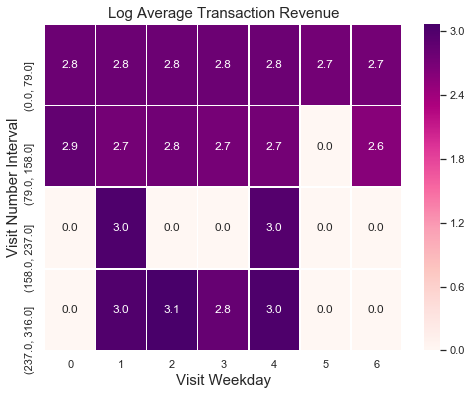

In [157]:
import seaborn as sns
import calendar
sns.set(rc={'figure.figsize':(8,6)})
american_df = train_df[train_df['geoNetwork.country']=='United States']
transaction_weekday_visnum = american_df[['visit_weekday', 'visitNumber', 'totals.transactionRevenue']]
transaction_weekday_visnum = transaction_weekday_visnum.groupby(['visit_weekday', 
                                                             pd.cut(transaction_weekday_visnum["visitNumber"], 
                                                                    np.arange(0, transaction_weekday_visnum['visitNumber'].max(), transaction_weekday_visnum['visitNumber'].max()/5)).rename('visitnumbin')]).sum()
# transaction_continent_os.rename(columns={'ID':'COUNT','TIME':'MEAN_TIME'})
transaction_weekday_visnum.drop(columns=['visitNumber'], inplace=True)
transaction_weekday_visnum = transaction_continent_os.reset_index()
transaction_weekday_visnum['totals.transactionRevenue'] = np.log1p(transaction_weekday_visnum['totals.transactionRevenue'])
twv_pivot = transaction_weekday_visnum.pivot('visitnumbin', 'visit_weekday', 'totals.transactionRevenue')
# twv_pivot.head()
# transaction_weekday_visnum.head()
plt.title('Log Average Transaction Revenue', size = 15)
sns.heatmap(twv_pivot, annot=True, fmt=".1f", linewidths=.5, square = False, cmap = 'RdPu')
plt.xlabel('Visit Weekday', size = 15)
plt.ylabel('Visit Number Interval', size = 15)

Text(0.5,1,'Log Transaction Revenue of Weekdays')

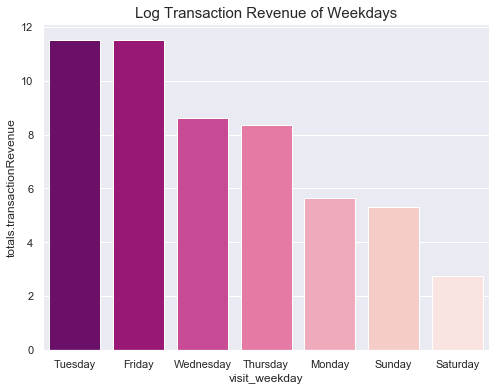

In [209]:
# transaction_weekday_visnum['totals.transactionRevenue'] = np.exp(transaction_weekday_visnum['totals.transactionRevenue']) - 1
transaction_weekday = transaction_weekday_visnum.groupby(['visit_weekday']).sum()
transaction_weekday.head()
transaction_weekday = transaction_weekday.reset_index()
worder = transaction_weekday.sort_values('totals.transactionRevenue', ascending=False)
twg = sns.barplot(x='visit_weekday', y='totals.transactionRevenue', data=transaction_weekday, palette=sns.color_palette("RdPu_r", 7), order=worder['visit_weekday'])
twg.set(xticklabels = [list(calendar.day_name)[int(i)] for i in worder.visit_weekday])
twg.set_title("Log Transaction Revenue of Weekdays", size=15)

[[Text(0,0,'Wednesday'),
  Text(0,0,'Tuesday'),
  Text(0,0,'Thursday'),
  Text(0,0,'Monday'),
  Text(0,0,'Friday'),
  Text(0,0,'Saturday'),
  Text(0,0,'Sunday')]]

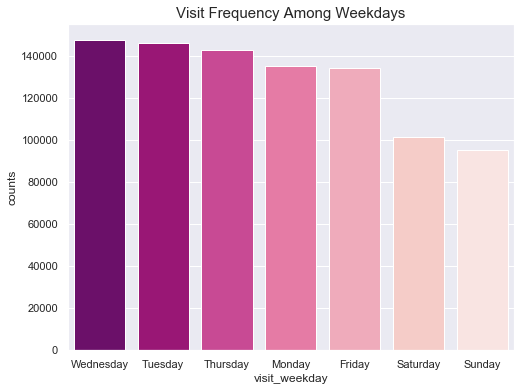

In [210]:
hit_weekday = train_df[['visit_weekday']].groupby(['visit_weekday']).size().reset_index()
hit_weekday.rename(columns={0:'counts'}, inplace=True)
hit_weekday.head()
hworder = hit_weekday.sort_values(['counts'], ascending=False)
hwg = sns.barplot(x='visit_weekday', y='counts', data=hit_weekday, palette=sns.color_palette("RdPu_r", 7), order=hworder['visit_weekday'])
hwg.set_title("Visit Frequency Among Weekdays", size=15)
hwg.set(xticklabels = [list(calendar.day_name)[int(i)] for i in hworder.visit_weekday])

**Transaction revenue is correlated with days of a week.** 
From both of the three plots, I observe that people more tend to explore online stores from Tuesday to Friday than the weekend, especially the store which they have visited for many times. 
People are hanging out on Saturdays and Sundays so there is less transcation revenue. 
On normal weekdays people get off work and open their devices to have a look of these stores. They can even open it everytime and everywhere during a day if they have a short rest. 
Interestingly, people explore less on Monday. The first day of a week usually has a lot of work to do and their bosses may watching them for not deserting. 

**It seems that costomers have a peak shopping efficiency on Friday** because the frequency of visiting online stores on Friday is in the 5th place, however, the transaction revenue on that day almost riches the same value as Wednesday which is in the first place. This could be explained by people's action being affected by emotion. People think Friday is the last day they have to work so they usually have a more excited mood. They are impetuous to buy more with less exploration.

Also, **transaction revenue is correlated with times of a customer visiting**. The stores visited by people more frequently have more chances to make a deal with higher transaction revenue. This could be interpreted as a kind of trust from frequent guests. But, there is a small counter phenomenon on Friday. People on Saturday and Sunday who are still sticked to their devices might be veterans in online shopping. Their exploration on stores they had never been to is hunting for big sales!

## 3 Geographic Information
I choose `geoNetwork.continent`, `device.deviceCategory` and `totals.transactionRevenue` to explore geographic information. I want to figure out the preference of online shopping methods amoung different continents. What's more, I'm interested in whether the shopping method will influence the transaction revenue.

As a result, I plot these values on a heatmap and bar charts.

First, plot the average log transaction revenue from different devices in continents.

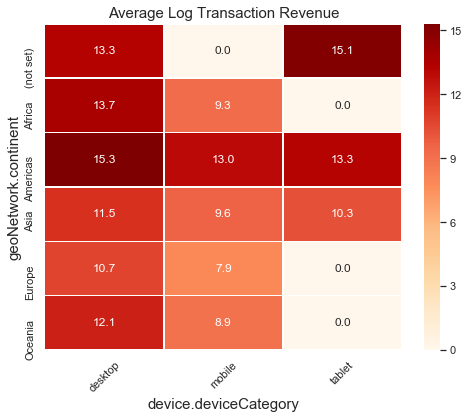

In [112]:
transaction_mobile_continent = train_df[['geoNetwork.continent', 'device.deviceCategory', 'totals.transactionRevenue']]
transaction_mobile_continent = transaction_mobile_continent.groupby(['geoNetwork.continent', 'device.deviceCategory']).mean()
transaction_mobile_continent = transaction_mobile_continent.reset_index()
transaction_mobile_continent['totals.transactionRevenue'] = np.log1p(transaction_mobile_continent['totals.transactionRevenue'])
tmc_pivot = transaction_mobile_continent.pivot('geoNetwork.continent', 'device.deviceCategory', 'totals.transactionRevenue')
plt.xlabel('Device Category', size = 15)
plt.ylabel('Continent', size = 15)
plt.xticks(rotation=45)
plt.title('Average Log Transaction Revenue', size = 15)
sns.heatmap(tmc_pivot, annot=True, fmt=".1f", linewidths=.5, square = False, cmap = 'OrRd')

Then, plot the ratio of device usage within each continent.

C:\Users\etoss\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5,1,'Device Usage Ratio')

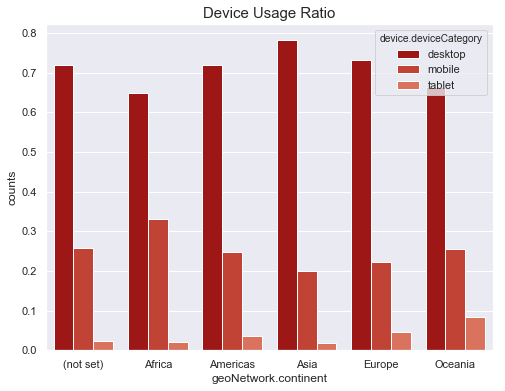

In [237]:
geo_device = train_df[['geoNetwork.continent', 'device.deviceCategory']].groupby(['geoNetwork.continent', 'device.deviceCategory']).size().reset_index()
geo_device.rename(columns={0:'counts'}, inplace=True)
for cname in set(geo_device['geoNetwork.continent'].values):
    s = geo_device['counts'][geo_device['geoNetwork.continent']==cname].sum()
    geo_device['counts'].loc[geo_device['geoNetwork.continent']==cname] = geo_device['counts'][geo_device['geoNetwork.continent']==cname]/s
# geo_device.head()
gdg = sns.barplot(x="geoNetwork.continent", y='counts', hue="device.deviceCategory", data=geo_device, palette=sns.color_palette("OrRd_r", 7))
gdg.set_title("Device Usage Ratio", size=15)

Finally, plot the average trasaction revenue made by different devices among continents. Note that here I only consider the success transactions, which means the transaction revenue should be greater than 0. The reason why I do so is to see for thoes who really buy something, is their any difference between devices they use.

Text(0.5,1,'Device Average Transaction Revenue of Success Transactinos')

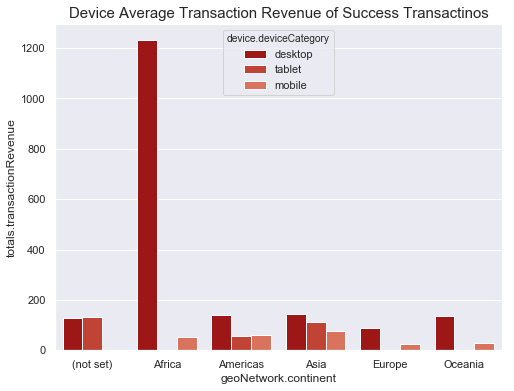

In [238]:
geo_device_t = train_df[['geoNetwork.continent', 'device.deviceCategory', 'totals.transactionRevenue']][train_df['totals.transactionRevenue']>0].groupby(['geoNetwork.continent', 'device.deviceCategory']).mean().reset_index()
geo_device_t['totals.transactionRevenue'] = geo_device_t['totals.transactionRevenue']/(10**6)
gdtg = sns.barplot(x="geoNetwork.continent", y='totals.transactionRevenue', hue="device.deviceCategory", data=geo_device_t, palette=sns.color_palette("OrRd_r", 7))
gdtg.set_title("Device Average Transaction Revenue of Success Transactinos", size=15)

From the plots above I obtain the information that **people all round the world are more likely to use desktop devices to shop online**. The distributions of device usage in different continents are **similar**. 

Specifically, African people use mobile devices more than others, but actually, those who use desktop devices buy goods **much more valuable** than the mobile. This can be explained by the popularize of mobile devices as well as **the extremely large gap between the rich and the poor in Africa**. 

Asian people use tablet least but those tablet users contribute more average revenue than the mobile. 

It's fun to figure out from those plots that people like to **buy more expansive stuff by using larger devices**. This is due to the both techincal stability and reliablity, and psycological security of desktop devices. I speculate that people using desktop think they won't **be frauded**, and **abundant details and reviews** from other customers about the item on the screen will let them more confident to decide buying an expansive item.

## 4 Buying score

A score, no matter it is a buying score or a selling score, is aimed to establish an easy way to evaluate the sample based on a set of features. It represents 

In [240]:
nfs = train_df[NUM_FEATURE_NAMES]
nfs.describe()

,visitNumber,totals.hits,totals.pageviews,totals.newVisits
count,903653.000000,903653.000000,903553.000000,703060.0
mean,2.264897,4.596538,3.849764,1.0
std,9.283735,9.641437,7.025274,0.0
min,1.000000,1.000000,1.000000,1.0
25%,1.000000,1.000000,1.000000,1.0
50%,1.000000,2.000000,1.000000,1.0
75%,1.000000,4.000000,4.000000,1.0
max,395.000000,500.000000,469.000000,1.0


## 5 External Dataset
 - [City of Average Monthly Net Salary](https://www.numbeo.com/cost-of-living/city_price_rankings?itemId=105) from https://www.numbeo.com/cost-of-living/city_price_rankings?itemId=105 
 - [Property Price](https://www.numbeo.com/property-investment/country_result.jsp) from https://www.numbeo.com/cost-of-living/city_price_rankings?itemId=105
 - [Food Price](https://www.numbeo.com/food-prices/country_result.jsp) from https://www.numbeo.com/food-prices/country_result.jsp
 
It's a good reference for this task to have a preview that a customer having more or less purchasing power. But, the higher income doesn't direcly mean a corresponding purchasing power. With the help of **property price** and **food price**, it's easy to roughly estimate the average **disposable income** of a district by using **net salary** minus food price and a certain type of property price (for example, renting an apartment). The higher purchasing power, the higher probability to make a big deal. 



In [239]:
# [//]: - [World Cities Database(Basic)](https://simplemaps.com/data/world-cities) from https://simplemaps.com/data/world-cities
#   I can find the 

## 6 Establish a model

In [56]:
import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder

train_y = np.log1p(train_df["totals.transactionRevenue"].values)
train_id = train_df['fullVisitorId'].values
test_id = test_df['fullVisitorId'].values


# label encode the categorical variables and convert the numerical variables to float
for col in CAT_FEATURE_NAMES:
    lbl = LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

for col in NUM_FEATURE_NAMES:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)
    
train_df.head()
    


,channelGrouping,fullVisitorId,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,...,trafficSource.adwordsClickInfo.slot,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.source,visit_year,visit_month,visit_day,visit_hour,visit_weekday
0,4,1131660440785968503,1.0,35,0,0,20,378,3,210,...,3,0,11,5,208,0,11,11,7,4
1,4,377306020877927890,1.0,43,0,0,7,955,5,12,...,3,0,11,5,208,0,11,22,19,5
2,4,3895546263509774583,1.0,35,0,0,20,475,4,185,...,3,0,11,5,208,0,11,22,1,5
3,4,4763447161404445595,1.0,79,0,0,6,955,3,94,...,3,0,1607,5,208,0,11,22,19,5
4,4,27294437909732085,2.0,35,1,1,1,955,4,217,...,3,0,11,5,208,0,11,11,5,4


In [66]:
dev_X, valid_X, dev_y, valid_y = sl.model_selection.train_test_split(
    train_df[FEATURE_COLUMN_NAMES+['fullVisitorId', 'totals.transactionRevenue']], train_y, train_size=0.8, random_state=1)



valid_pred_X = pd.DataFrame({"fullVisitorId":valid_X["fullVisitorId"].values})
valid_pred_X["transactionRevenue"] = valid_X["totals.transactionRevenue"].values
dev_X.drop(columns=['fullVisitorId', 'totals.transactionRevenue'], inplace=True)
valid_X.drop(columns=['fullVisitorId', 'totals.transactionRevenue'], inplace=True)
test_X = test_df[FEATURE_COLUMN_NAMES]

E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [67]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        'nthread': 4,
        "num_leaves" : 30,
        'subsample': 0.8,
        "metric" : "rmse", 
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 20,
        "bagging_seed" : 519,
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 100,
        'scale_pos_weight':1,
        "verbosity" : -1
    }
    
    lgtrain = lgbm.Dataset(train_X, label=train_y)
    lgval = lgbm.Dataset(val_X, label=val_y)
    model = lgbm.train(params, lgtrain, 10000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

In [68]:
# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, valid_X, valid_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.63078
[200]	valid_0's rmse: 1.61731
[300]	valid_0's rmse: 1.61075
[400]	valid_0's rmse: 1.6068
[500]	valid_0's rmse: 1.60471
[600]	valid_0's rmse: 1.60464
[700]	valid_0's rmse: 1.60329
[800]	valid_0's rmse: 1.60308
[900]	valid_0's rmse: 1.60308
Early stopping, best iteration is:
[853]	valid_0's rmse: 1.60278


In [69]:
from sklearn import metrics
pred_val[pred_val<0] = 0
# valid_pred_X = pd.DataFrame({"fullVisitorId":valid_X["fullVisitorId"].values})
# valid_pred_X["transactionRevenue"] = valid_df["totals.transactionRevenue"].values
valid_pred_X["PredictedRevenue"] = np.expm1(pred_val)
valid_pred_X = valid_pred_X.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(valid_pred_X["transactionRevenue"].values), np.log1p(valid_pred_X["PredictedRevenue"].values))))

1.59602593261


In [70]:
import time
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.shape
len(sub_df.fullVisitorId.unique())
sub_df.to_csv("predict\\{}_baseline_lgb.csv".format(time.time()), index=False)